In [1]:
import warnings
from fastai.vision import *
from fastai.callbacks import *
warnings.filterwarnings('ignore')
path = Path('../data/imagenette/imagenette-160')
sys.path.append("dev/")

In [2]:
path = untar_data(URLs.IMAGEWOOF_160)

In [3]:
(path/'train').ls()

[PosixPath('/home/ubuntu/.fastai/data/imagewoof-160/train/n02093754'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-160/train/n02088364'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-160/train/n02089973'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-160/train/n02087394'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-160/train/n02111889'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-160/train/n02099601'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-160/train/n02105641'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-160/train/n02086240'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-160/train/n02115641'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-160/train/models'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-160/train/n02096294')]

In [4]:
tfms = get_transforms(True, 
                      False,
                      max_rotate=15,
                      max_zoom=1.3,
                      max_lighting=0.3,
                      max_warp=0.2,
                      p_affine=0.5,
                      p_lighting=0.5)

In [5]:
sz = 128
data = (ImageList.from_folder(path=path/'train')    
        .random_split_by_pct(0.1)
        .label_from_folder()
        .transform(tfms, size=sz)
        .databunch(bs=64)
        .normalize())

In [6]:
# test data
test_data = (ImageList.from_folder(path=path/'val')
            .no_split()
            .label_from_folder()
            .transform(None, size=sz)
            .databunch(bs=64)
            .normalize(data.stats))

In [7]:
data.add_test(test_data.train_ds.x)

In [8]:
data

ImageDataBunch;

Train: LabelList (11209 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02093754,n02093754,n02093754,n02093754
Path: /home/ubuntu/.fastai/data/imagewoof-160/train;

Valid: LabelList (1245 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02096294,n02088364,n02099601,n02111889
Path: /home/ubuntu/.fastai/data/imagewoof-160/train;

Test: LabelList (500 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: /home/ubuntu/.fastai/data/imagewoof-160/train

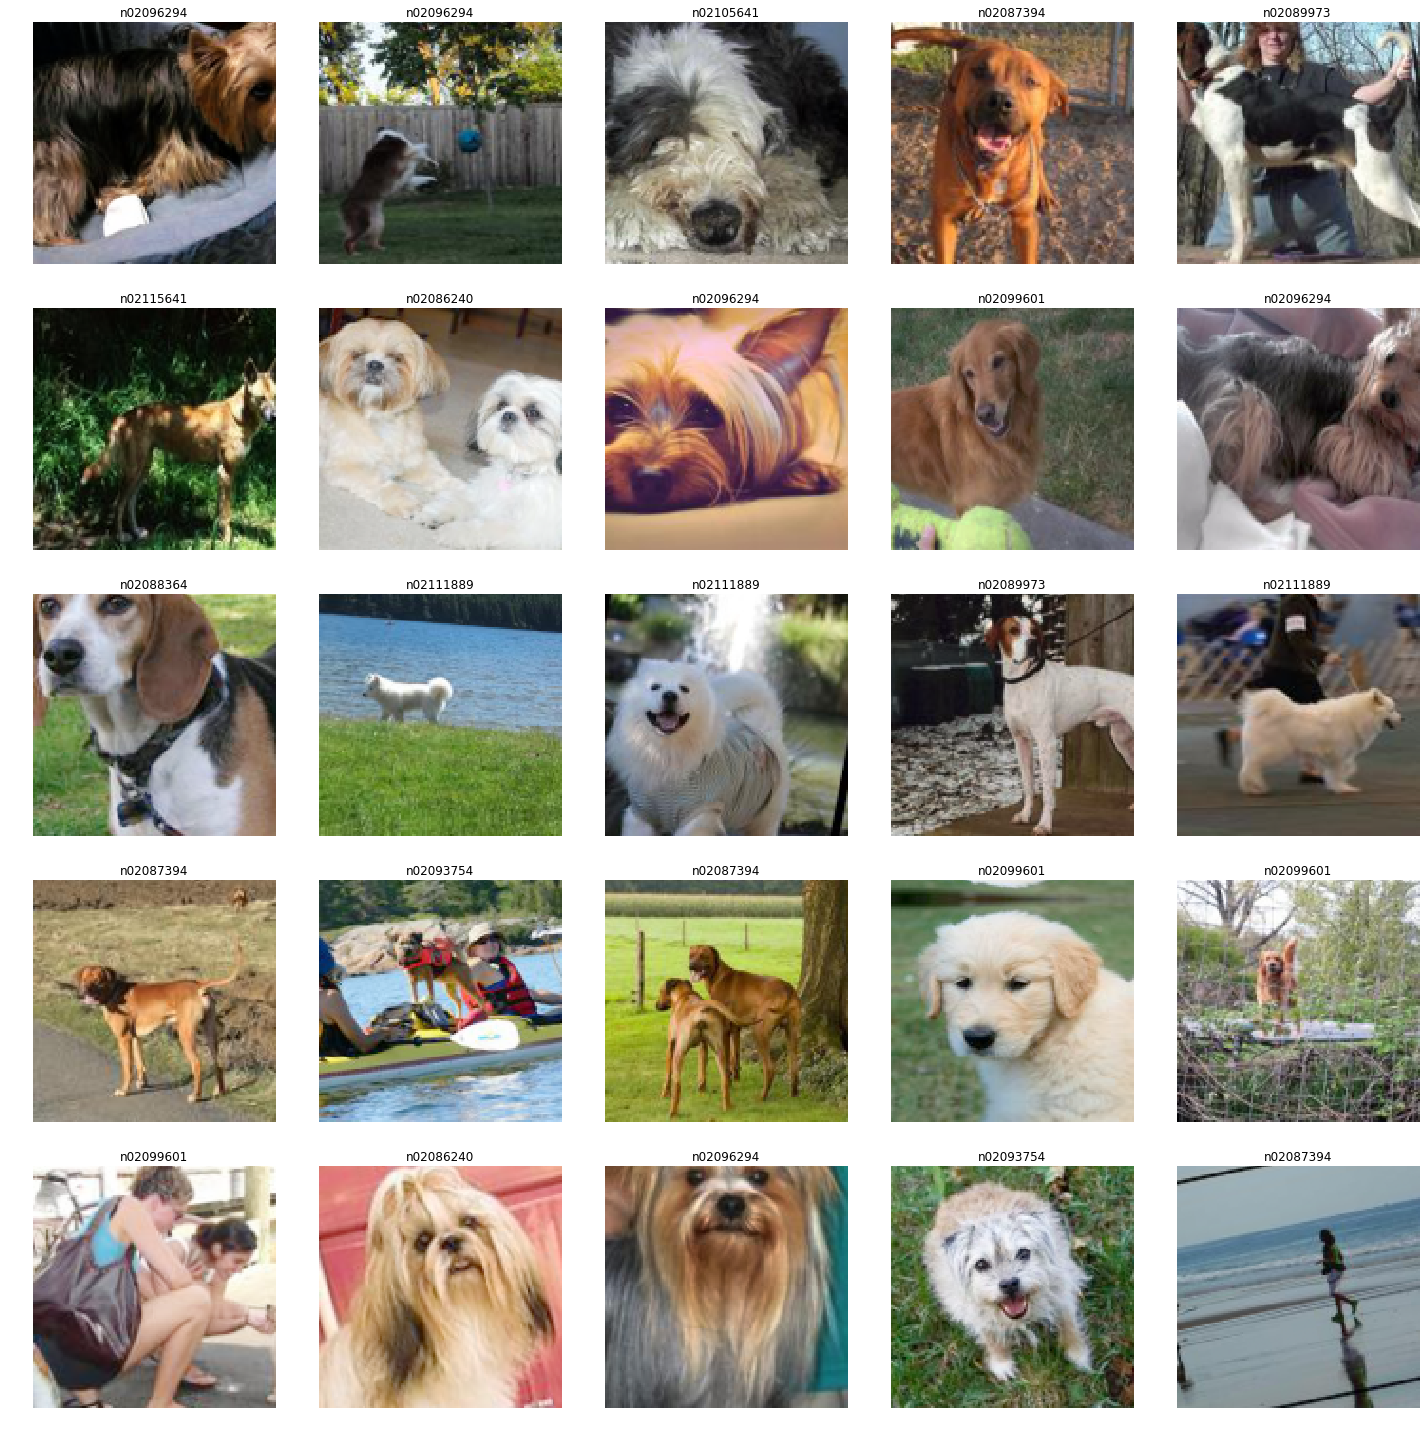

In [9]:
data.show_batch()

### Baseline

In [16]:
model_name = 'resnet18'
arch = getattr(models, model_name)

learn_callbacks = [TerminateOnNaNCallback()]
learn_callback_fns = [partial(EarlyStoppingCallback, monitor='accuracy', mode='max', patience=5),
                      partial(SaveModelCallback, monitor='accuracy', mode='max',
                              name='baseline'),
                      partial(CSVLogger, filename=f'../logs/{model_name}')]

learn = cnn_learner(data=data, 
                    base_arch=arch,
                    pretrained=False, 
                    metrics=[accuracy],
                    callbacks=learn_callbacks,
                    callback_fns=learn_callback_fns)

In [17]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=10, bias=True)
)

In [11]:
# learn.mixup(0.2)
# learn.loss_func = LabelSmoothingCrossEntropy()

In [12]:
# learn.lr_find()
# learn.recorder.plot()

In [18]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
______________________________________________________________

In [19]:
learn.fit_one_cycle(50, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.386094,2.083707,0.248193,00:34
1,2.242667,2.001300,0.284337,00:33
2,2.109479,1.914000,0.329317,00:33
3,2.010478,1.936243,0.300402,00:34
4,1.890892,2.019912,0.301205,00:34
5,1.812717,1.994257,0.334137,00:34
6,1.695865,1.712278,0.394377,00:34
7,1.636871,1.811379,0.355823,00:33
8,1.536066,1.679464,0.413655,00:33
9,1.471800,2.099721,0.359036,00:33


Better model found at epoch 0 with accuracy value: 0.24819277226924896.
Better model found at epoch 1 with accuracy value: 0.2843373417854309.
Better model found at epoch 2 with accuracy value: 0.32931727170944214.
Better model found at epoch 5 with accuracy value: 0.3341365456581116.
Better model found at epoch 6 with accuracy value: 0.3943774998188019.
Better model found at epoch 8 with accuracy value: 0.413654625415802.
Better model found at epoch 10 with accuracy value: 0.5349397659301758.
Better model found at epoch 12 with accuracy value: 0.5534136295318604.
Better model found at epoch 15 with accuracy value: 0.6594377756118774.
Better model found at epoch 18 with accuracy value: 0.6634538173675537.


KeyboardInterrupt: 

In [ ]:
learn.callbacks = []
def TTA_score(load_pth='baseline'):
    learn.load(load_pth)
    preds = learn.TTA(ds_type=DatasetType.Test)
    test_preds = torch.argmax(preds[0], 1)
    test_preds = to_np(test_preds)
    test_labels = test_data.train_ds.y.items
    print(f"top1 acc: {np.mean(test_labels == test_preds)}")

def non_TTA_score(load_pth='baseline'):
    learn.load(load_pth)
    preds = learn.get_preds(ds_type=DatasetType.Test)
    test_preds = torch.argmax(preds[0], 1)
    test_preds = to_np(test_preds)
    test_labels = test_data.train_ds.y.items
    print(f"top1 acc: {np.mean(test_labels == test_preds)}")

In [ ]:
non_TTA_score()

In [ ]:
TTA_score()

### Bag of Tricks 

https://arxiv.org/pdf/1812.01187.pdf

#### 1. Large batch 

**Large Batch Size Training**

- Increase learning rate as lr x bs_new/bs_old

**Warmup with first m batches**

- Linearly increase learning rate to lr in first m batches 

**Set $\gamma$ = 0 in BN layers in ResBlocks**

- Mimics a network with less parameters at the beginning of training

**No wd (L2 reg) in bias, or BN params $\gamma, \beta$**

#### 2. Low Precision

**FP16 Training**

#### 3. ResNet Tweaks

ResNetB, ResNetC, ResNetD...

#### 4. Cosine Annealing LR

#### 5. Label Smoothing

LabelSmoothingCrossEntropy()

#### 6. Student Teacher

$(p,softmax(z)) + T^{2}(softmax(r/T),softmax(z/T))$

#### 7. Mixup Training